# Surplus Study

**The purpose of this study is to measure the surplus for historic COW trades for a desired token pair.** 

**Methodology:** 
- Assume a Feedlot AMM with CPMM preferences that only trades COW orders.
- Given a dataset that represents the list of all trades that happened on COW Swap with value over $100 with first trade at timestamp t0. 
- Inputs: 
    - Token1: Token1 of token pair to be studied 
    - Token2: Token2 of token pair to be studied 
    - token1_starting_reserves: Starting reserves of the feedlot AMM pool. 
    - fee_rate: Fee rate charged to the trade 
  
- Initialize a feedlot AMM for token1 and token2, at t0 with the price of the first trade at t0 of the COW dataset of token1 and token2, using the starting reserves given by the input (calculating token1_starting_reserves * price@t0) 

- Loop through all trades and check at each trade if Pfeedlot < Pcow_execution. (This is also given by k_new > k_current). If the price of feedlot was favourable then trade is executed on Feedlot AMM and new reserves are updated. 





**Surplus Calculations:** 

Surplus is defined by (Pfeedlot - Pmarket) * quantity 


- Surplus_price: defined as the surplus in price terms defined as follows:
    - Pfeedlot = X / Y 
    - Pmarket = dx / dy 
    - surplus_ price = Pfeedlot - Pmarket 
      
- Surplus_usdt: Surplus volume in USD terms defined as follows: 
    - surplus_price * dy  
Note: Since P is defined generally here as X / Y (or dx / dy for a swap) then the quantity to multiply to obtain surplus is dy. 

## 1. Loading Dataset 

Copy the dataset file into the folder that contains this notebook. 

In [89]:
import pandas as pd

# load raw trades data of COW swap 
df = pd.read_csv('cow_swaps.csv', low_memory=False)

In [90]:
# prepare table structure and needed columns for analysis 


# calculate buy and sell amounts from the correct decimall 
df['buy_amount'] = df.apply(lambda x: x['buyAmount'] / (10**x['buyTokenDecimals']), axis=1)
df['sell_amount'] = df.apply(lambda x: x['sellAmount'] / (10**x['sellTokenDecimals']), axis=1)

# filter the columsn needed and rename 
df = df[['timestamp', 'buyTokenSymbol', 'sellTokenSymbol', 'buy_amount', 'sell_amount','sellAmountUsd']]
df = df.rename(columns={"sellAmountUsd": "trade_value_usd", "buyTokenSymbol":"buy_token", "sellTokenSymbol":"sell_token"})

# Add new empty columns needed for analysis & specify their data types 
df['price'] = 0.0                  # .iloc 6
df['surplus_usdt'] = 0.0           # .iloc 7 
df['surplus_price'] = 0.0          # .iloc 8 
df['surplus_percent'] = 0.0        # .iloc 9
df['executed'] = False             # .iloc 10 

df['price'] = df['price'].astype(float)
df['surplus_usdt'] = df['surplus_usdt'].astype(float)
df['surplus_price'] = df['surplus_price'].astype(float)
df['surplus_percent'] = df['surplus_percent'].astype(float)
df['executed'] = df['executed'].astype(bool)

print(df.head(5))

    timestamp buy_token sell_token  buy_amount  sell_amount  trade_value_usd  \
0  1663907363       FXS       USDC    917.0115    4093.3944        4093.3944   
1  1668043871       FXS       USDC   8621.1068   45331.4992       45331.4992   
2  1669126187       FXS       USDC   1583.1120    6719.0000        6719.0000   
3  1662029515       FXS       USDC    369.8208    2138.3282        2138.3282   
4  1653185840       FXS       USDC   8901.6477   59366.1911       59366.1911   

   price  surplus_usdt  surplus_price  surplus_percent  executed  
0 0.0000        0.0000         0.0000           0.0000     False  
1 0.0000        0.0000         0.0000           0.0000     False  
2 0.0000        0.0000         0.0000           0.0000     False  
3 0.0000        0.0000         0.0000           0.0000     False  
4 0.0000        0.0000         0.0000           0.0000     False  


## 2. Define Surplus calculation function 

Detailed steps of the function: 

1. Filter the dataset for token1 and token2 trades only
2. Calculate price for each trade based on whether token1 was the buy or token2
3. Use the price of the first trade to initialize the feedlot AMM pool with token1_starting_reserves
3. Loop through trades and check if k_new > k and if yes, execute trade by reflecting new reserves level 



To fix: 
1. Fee calculation methodology 
2. Change starting reserves paradigm to tvl paradigm as its more relateabl 
  

In [91]:
from datetime import datetime


def surplus_analysis(token1:str, token2:str, token1_starting_reserves:int, fee_rate:float):
    
    """
    Perform surplus analysis for specific trading pair given by token1 and token2. 

    This function filters the required tokens for the simulation, initializes a feedlot AMM (CPMM) with starting 
    price corresponding to first trade in the list and a given initial reserves, loops through trade by trade and 
    checks if Pfeedlot < Pmarket. If yes (k_new > k_current), it executes the trade in Feedlot using the standard 
    CPMM formula. 

    Parameters:
        token1 (str): The first token to perform the surplus analysis on.
        token2 (str): The second token to perform the surplus analysis on.
        token1_starting_reserves (int): The starting reserves of token1.
        fee_rate (float): The fee rate for the transactions.

    Returns:
        trades_executed_percentage : Percentage of trades executed on Feedlot AMM that met the condition Pfeedlot < Pmarket
        executed_volume_percentage : volume of executed trades as percentage of total volume of swaps for token1 and token2
        total_surplus: Sum of surplus in USD terms 
    
    """
    
    
    # Filter the required tokens for the simulation 
    dfs = df[((df.buy_token == token1) & (df.sell_token == token2)) | ((df.sell_token == token1) & (df.buy_token == token2))]
    dfs.sort_values(by='timestamp', ascending=True, inplace=True)
    dfs = dfs[dfs['trade_value_usd'] > 100]
    dfs = dfs.reset_index(drop=True)
    
    
    # Calculate price column. Check if its a buy or a sell and calculate accordingly. 
    for i in range(len(dfs)):
        if dfs.iloc[i,1] == token1:
            dfs.iloc[i,6] = dfs.iloc[i,3] / dfs.iloc[i,4]  

        if dfs.iloc[i,1] == token2:
            dfs.iloc[i,6] = dfs.iloc[i,4] / dfs.iloc[i,3]
            
    dfs = dfs[dfs['price'] != 0]
    
    
    # initialize AMM pool 
    s = fee_rate 
    initialization_price = dfs.iloc[0,6]  
    token2_starting_reserves = token1_starting_reserves / initialization_price
    x = token1_starting_reserves 
    y = token2_starting_reserves 
    k = x * y 
    
    print('****** Feedlot AMM Initial State **********')
    print('''AMM Initialized with the following parameters:
    initilization price = {}
    x= {}
    y= {}
    k= {}
    s= {}'''.format(initialization_price, token1_starting_reserves, token2_starting_reserves, k, s))

    dfs.to_csv('debug1.csv', index=False)

    # Iterating through trades and checking if the trade would have been executed through Feedlot AMM
    # The condition is k_new > k  
    # Variables to monitor (trades: total trades executed, fees: total fees collected, volume : total volume executed) 

    trades  = 0 
    fees = 0 
    volume = 0 
    
    for i in range(len(dfs)):
        # if token_1 is the "buy token"
        if dfs.iloc[i,1] == token1:
            dx = dfs.iloc[i,3]
            dy = dfs.iloc[i,4]
            k_new = (x - dx) * (y + (1+s)*dy) 
            
            if k_new > k:
                surplus_price = abs((x / y)- dfs.iloc[i,6])
                dfs.iloc[i,7] =  surplus_price * dy 
                dfs.iloc[i,8] = surplus_price
                dfs.iloc[i,9] = surplus_price / dfs.iloc[i,6] * 100 # percentage
                dfs.iloc[i,10] = 1 # trade executed signal 
                volume = volume + dfs.iloc[i,5]
                fees = fees + (s * dfs.iloc[i,5]) 
                trades = trades + 1 
                k = k_new 
                x = x - dx
                y = y + (1+s)*dy 

        # if token_2 is the "buy token"
        elif dfs.iloc[i,1] == token2:
            dx = dfs.iloc[i,4] 
            dy = dfs.iloc[i,3]
            k_new = (x + (1+s)*dx) * (y - dy)    
            if k_new > k: 
                surplus_price = abs((x / y)- dfs.iloc[i,6])
                dfs.iloc[i,7] =  surplus_price * dy 
                dfs.iloc[i,8] = surplus_price
                dfs.iloc[i,9] = surplus_price / dfs.iloc[i,6] * 100 # percentage
                dfs.iloc[i,10] = 1 # trade executed signal 
                volume = volume + dfs.iloc[i,5]
                fees = fees + (s * dfs.iloc[i,5]) 
                trades = trades + 1 
                k = k_new 
                x = x + (1+s)*dx
                y = y - dy

    dfs.to_csv('debug2.csv', index=False)

    # Analysis results 
    
    total_trades = len(dfs) 
    total_volume = dfs['trade_value_usd'].sum()
    total_surplus = dfs['surplus_usdt'].sum() 

    trades_executed_percentage = trades / total_trades * 100 
    executed_volume_percentage = volume / total_volume * 100 
    total_surplus_percentage = total_surplus/ total_volume *100
    
    print('******** Results Data **********************')
    print('  Inputs:')
    print('token1', token1)
    print('token2', token2)
    print('initial Reserves', token1_starting_reserves)
    print('fee rate')
    print('  dataset timeframe:')
    print('starting date', datetime.utcfromtimestamp(dfs.iloc[0,0]).strftime('%Y-%m-%d'))
    print('ending date', datetime.utcfromtimestamp(dfs.iloc[-1,0]).strftime('%Y-%m-%d'))
    print('  Trades:')
    print('trades executed = ', trades)
    print('total_trades= ', total_trades)
    print('percentage of trades executed = ', trades_executed_percentage, '%') 
    print('  Volume:')
    print('total usd volume traded on feedlot= ', volume)
    print('total USD volume traded on COW', total_volume)
    print('volume percentage = ', volume / total_volume *100 , '%')
    print('  Surplus:')
    print('total surplus', total_surplus)
    print('surplus percentage of volume', total_surplus_percentage, '%')
    print('  LP metrics:')
    print('fees collected', fees)  
    print()
    
    return trades_executed_percentage, executed_volume_percentage, total_surplus
                


## 3. USDC-WETH Study

### a. Initial Reserves

Holding Fee level = 0 %   
Variable: Initial Reserves 

[Study range: USD 100,000 - USD 1,000,000,000]

Note: 
Uni v2 USDC-WETH current reserves TVL : USD 86,620,798   
Uni v3 USDC-ETH current reserves TVL : 390,840,000 USD (Combining 0.3% pool + 0.05% pool )  


/tmp/ipykernel_26872/3782219025.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='timestamp', ascending=True, inplace=True)


****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 100000
    y= 36.65071004703349
    k= 3665071.004703349
    s= 0
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 100000
fee rate
  dataset timeframe:
starting date 2021-08-06
ending date 2022-12-30
  Trades:
trades executed =  6775
total_trades=  24990
percentage of trades executed =  27.110844337735095 %
  Volume:
total usd volume traded on feedlot=  7213000.03558007
total USD volume traded on COW 1760806826.3872843
volume percentage =  0.4096417578286689 %
  Surplus:
total surplus 352919.0742521745
surplus percentage of volume 0.020043031919422548 %
  LP metrics:
fees collected 0.0

****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 50100000
    y= 18362.00573356378
    k= 919936487251.5453
    s= 0
******** Results Data *

****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 550100000
    y= 201615.55596873123
    k= 110908717338399.05
    s= 0
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 550100000
fee rate
  dataset timeframe:
starting date 2021-08-06
ending date 2022-12-30
  Trades:
trades executed =  11641
total_trades=  24990
percentage of trades executed =  46.582633053221286 %
  Volume:
total usd volume traded on feedlot=  714205160.6469449
total USD volume traded on COW 1760806826.3872843
volume percentage =  40.561244421814706 %
  Surplus:
total surplus 95977190.46065933
surplus percentage of volume 5.450750702595778 %
  LP metrics:
fees collected 0.0

****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 600100000
    y= 219940.91099224798
    k= 131986540686448.02
    s= 0
******** Resu

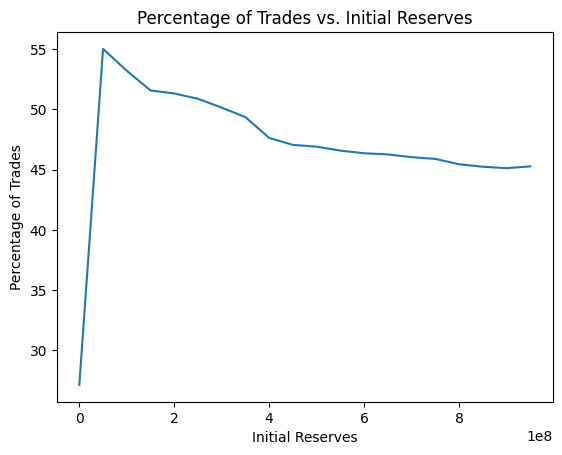

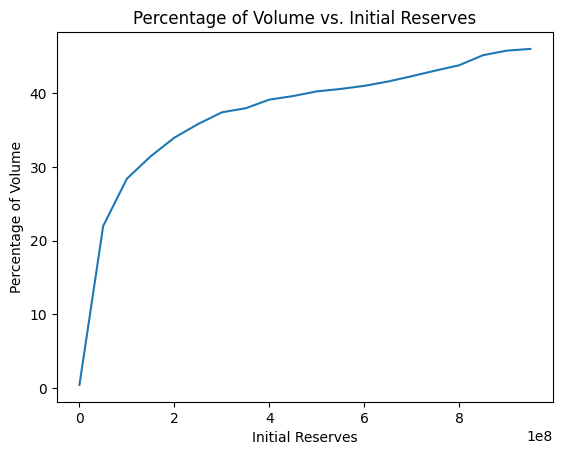

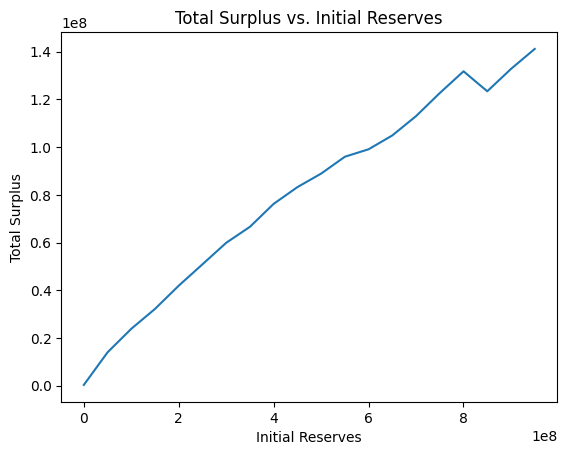

In [93]:
import matplotlib.pyplot as plt


token1 = "USDC"
token2 = "WETH"
fee_rate = 0

# Study Starting reserves impact on key variables 

x = []
y1 = []
y2 = []
y3 = []


#range from 10mln to 1bn in 50mn increments for starting reserves. 
for token1_starting_reserves in range(100000, 1000100000, 50000000):
    x.append(token1_starting_reserves)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1.append(trades_executed_percentage)
    y2.append(executed_volume_percentage)
    y3.append(total_surplus)
    
    
df = pd.DataFrame({'starting reserves': x, '% of trades executed': y1, '% of volume executed': y2, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df)


# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

plt.show()


#### Discussion: 

- Weird that % of trades rises and reaches a max then falls off. Thought it would be strictly increasing. 
- weird that surplus is linear wrt initial reserves

### b. Fee level 

## 4. DAI - USDT Study

### a. Initial Reserves

Holding Fee level = 0 %
Variable: Initial Reserves

(Study range: USD 100,000 - USD 1,000,000,000)

Note: Uni v2 USDC-WETH current reserves TVL : USD  (corresponds to initial reserves 43,310,399 in our study) Uni v3 USDC-WETH current reserves TVL : USD 230,510,000 (reserves DAI = USD 114,981,000


In [ ]:
import matplotlib.pyplot as plt


token1 = "DAI"
token2 = "USDT"
fee_rate = 0

# Study Starting reserves impact on key variables 

x = []
y1 = []
y2 = []
y3 = []


#range from 10mln to 1bn in 50mn increments for starting reserves. 
for token1_starting_reserves in range(100000, 1000100000, 50000000):
    x.append(token1_starting_reserves)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1.append(trades_executed_percentage)
    y2.append(executed_volume_percentage)
    y3.append(total_surplus)
    
    
df = pd.DataFrame({'starting reserves': x, '% of trades executed': y1, '% of volume executed': y2, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df)


# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

plt.show()
